Epoch 1/50


C:\Users\SUJAL\AppData\Local\Temp\ipykernel_31624\542780938.py:31: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0613 - val_loss: 0.0012
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - val_loss: 8.5599e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020 - val_loss: 8.3510e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021 - val_loss: 8.1769e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021 - val_loss: 9.0856e-04
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss

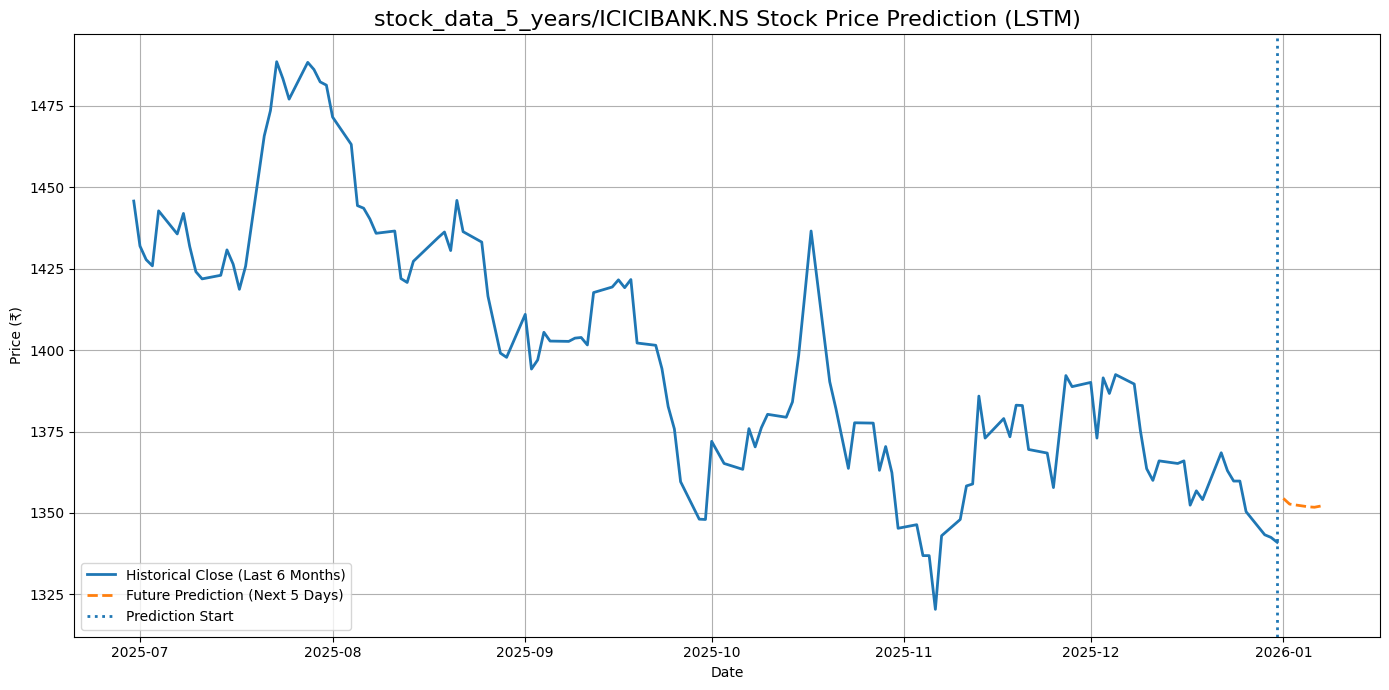


🔮 FUTURE PRICE PREDICTIONS
----------------------------
Day +1: ₹1354.47
Day +2: ₹1352.73
Day +3: ₹1351.90
Day +4: ₹1351.76
Day +5: ₹1352.12


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.tseries.offsets import BDay, DateOffset

# ===============================
# CONFIGURATION
# ===============================
CSV_FILE_NAME = "stock_data_5_years/ICICIBANK.NS.csv"   # 🔁 Change any stock CSV
TIME_STEPS = 60
FUTURE_DAYS = 5
MONTHS_TO_SHOW = 6
EPOCHS = 50
BATCH_SIZE = 32

# ===============================
# LOAD & CLEAN DATA
# ===============================
df = pd.read_csv(CSV_FILE_NAME)

df = df[pd.to_numeric(df['Open'], errors='coerce').notnull()]

cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[cols] = df[cols].astype(float)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

data = df[cols]

# ===============================
# SCALE DATA
# ===============================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# ===============================
# CREATE SEQUENCES
# ===============================
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 3])  # Close price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, TIME_STEPS)

# ===============================
# TRAIN-TEST SPLIT
# ===============================
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ===============================
# BUILD LSTM MODEL
# ===============================
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# ===============================
# TRAIN MODEL
# ===============================
model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

# ===============================
# MODEL ACCURACY (TEST DATA)
# ===============================
y_pred = model.predict(X_test)

dummy = np.zeros((len(y_test), 5))
dummy[:, 3] = y_test
y_test_actual = scaler.inverse_transform(dummy)[:, 3]

dummy[:, 3] = y_pred.flatten()
y_pred_actual = scaler.inverse_transform(dummy)[:, 3]

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

approx_accuracy = (1 - mae / np.mean(y_test_actual)) * 100

print("\n📊 MODEL PERFORMANCE")
print("----------------------------")
print(f"MAE   : ₹{mae:.2f}")
print(f"RMSE  : ₹{rmse:.2f}")
print(f"R²    : {r2:.3f}")
print(f"Approx Accuracy : {approx_accuracy:.2f}%")

# ===============================
# FUTURE PREDICTION (NEXT 5 DAYS)
# ===============================
last_window = scaled_data[-TIME_STEPS:]
future_predictions = []

for _ in range(FUTURE_DAYS):
    X_input = np.array([last_window])
    predicted_scaled = model.predict(X_input, verbose=0)

    next_day = last_window[-1].copy()
    next_day[3] = predicted_scaled[0][0]

    # Approximate OHLC
    next_day[0] = next_day[3]
    next_day[1] = next_day[3] * 1.01
    next_day[2] = next_day[3] * 0.99

    last_window = np.vstack([last_window[1:], next_day])

    dummy = np.zeros((1, 5))
    dummy[0, 3] = predicted_scaled[0][0]
    price = scaler.inverse_transform(dummy)[0, 3]

    future_predictions.append(price)

# ===============================
# CREATE FUTURE DATES
# ===============================
last_date = data.index[-1]
future_dates = [last_date + BDay(i) for i in range(1, FUTURE_DAYS + 1)]

# ===============================
# SHOW LAST N MONTHS ONLY
# ===============================
start_date = last_date - DateOffset(months=MONTHS_TO_SHOW)
recent_data = data.loc[start_date:last_date]

# ===============================
# PLOT GRAPH
# ===============================
plt.figure(figsize=(14, 7))

plt.plot(
    recent_data.index,
    recent_data['Close'],
    label=f"Historical Close (Last {MONTHS_TO_SHOW} Months)",
    linewidth=2
)

plt.plot(
    future_dates,
    future_predictions,
    linestyle="--",
    linewidth=2,
    label="Future Prediction (Next 5 Days)"
)

plt.axvline(
    x=last_date,
    linestyle=":",
    linewidth=2,
    label="Prediction Start"
)

plt.title(f"{CSV_FILE_NAME.replace('.csv','')} Stock Price Prediction (LSTM)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# PRINT FUTURE PREDICTIONS
# ===============================
print("\n🔮 FUTURE PRICE PREDICTIONS")
print("----------------------------")
for i, price in enumerate(future_predictions, 1):
    print(f"Day +{i}: ₹{price:.2f}")
